## sprint23課題 ゲート付きリカレントニューラルネットワーク②

### データセット:IMDB映画レビュー感情分類


In [0]:
# -*- coding: utf-8 -*-
"""Recurrent layers and their base classes.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings

from keras import backend as K
from keras.layers import Dense, Activation
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine.topology import Layer
from keras.engine.topology import InputSpec
from keras.utils.generic_utils import has_arg
from keras.utils.generic_utils import to_list
from keras.datasets import imdb

# Legacy support.
from keras.legacy.layers import Recurrent
from keras.legacy import interfaces


Using TensorFlow backend.


### LSTM

In [0]:
'''Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
# Notes
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 161s 6ms/step - loss: 0.4603 - acc: 0.7816 - val_loss: 0.4377 - val_acc: 0.8022
Epoch 2/15
25000/25000 [==============================] - 161s 6ms/step - loss: 0.3028 - acc: 0.8764 - val_loss: 0.3759 - val_acc: 0.8344
Epoch 3/15
25000/25000 [==============================] - 159s 6ms/step - loss: 0.2229 - acc: 0.9121 - val_loss: 0.4648 - val_acc: 0.8110
Epoch 4/15
25000/25000 [==============================] - 160s 6ms/step - loss: 0.1566 - acc: 0.9412 - val_loss: 0.4597 - val_acc: 0.8304
Epoch 5/15
25000/25000 [==============================] - 160s 6ms/step - loss: 0.1090 - acc: 0.9596 - val_loss: 0.6787 - val_acc: 0.8198
Epoch 6/15
25000/25000 [==============================] - 159s 6ms/step - loss: 0.0852 - acc:

LSTMで学習した結果（Epoch1〜15)、lossは0.46から0.015に低下したが、val_lossは0.43から1.11に上がった。

### ConvLSTM2D

Using TensorFlow backend.


Train on 950 samples, validate on 50 samples
Epoch 1/5
950/950 [==============================] - 2838s 3s/step - loss: 0.2642 - val_loss: 0.0909
Epoch 2/5
950/950 [==============================] - 2844s 3s/step - loss: 0.0236 - val_loss: 0.0124
Epoch 3/5
950/950 [==============================] - 2834s 3s/step - loss: 0.0035 - val_loss: 0.0027
Epoch 4/5
950/950 [==============================] - 2816s 3s/step - loss: 0.0012 - val_loss: 0.0985
Epoch 5/5
950/950 [==============================] - 2805s 3s/step - loss: 0.0111 - val_loss: 0.0020


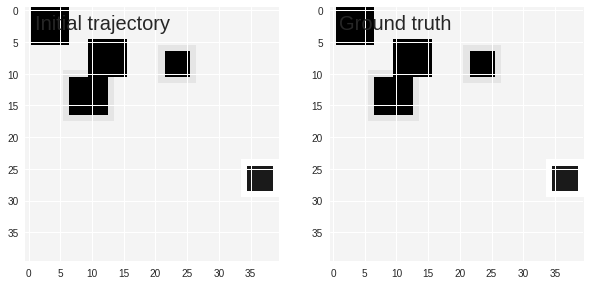

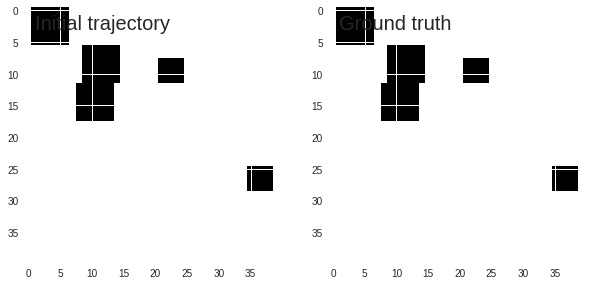

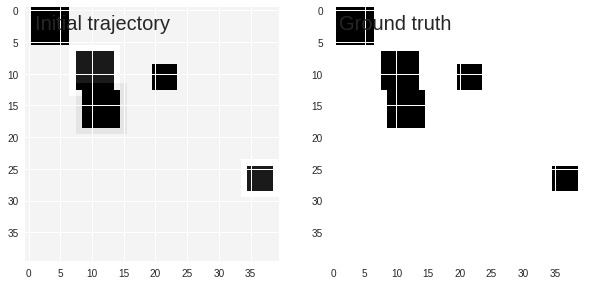

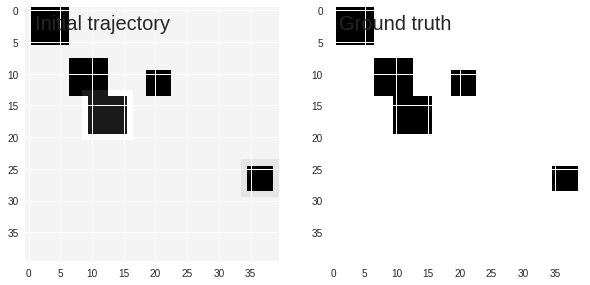

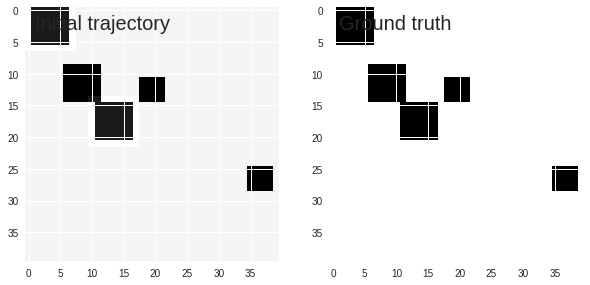

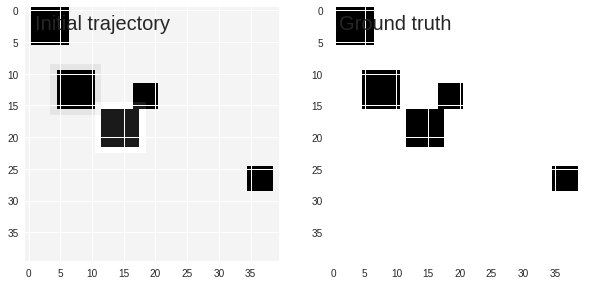

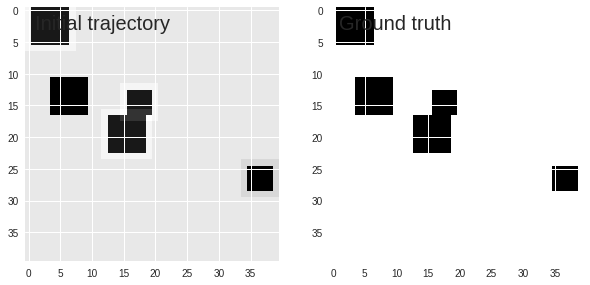

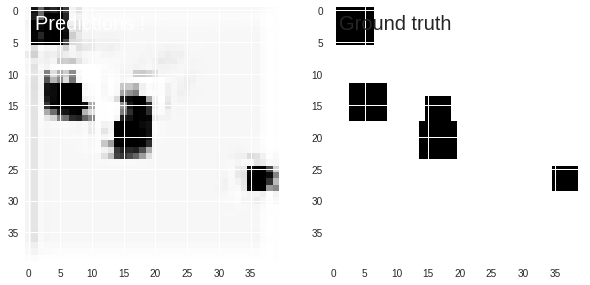

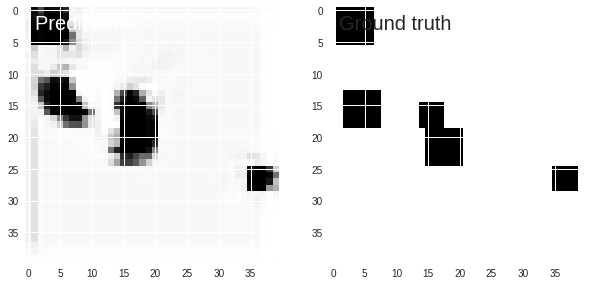

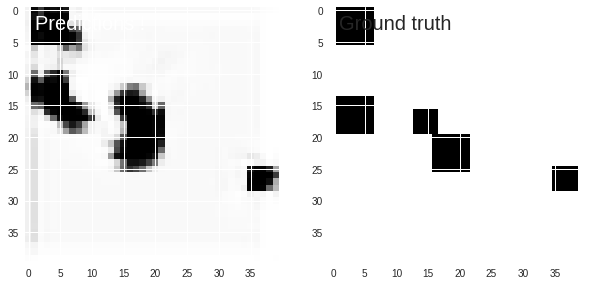

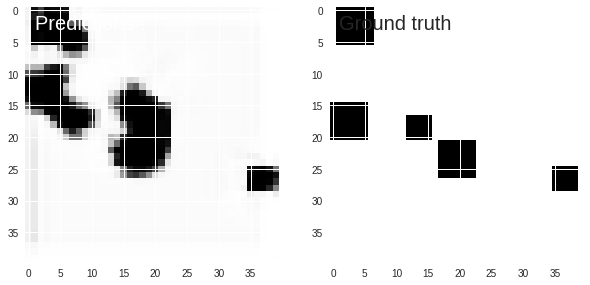

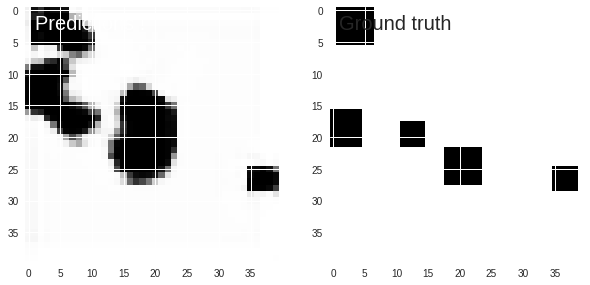

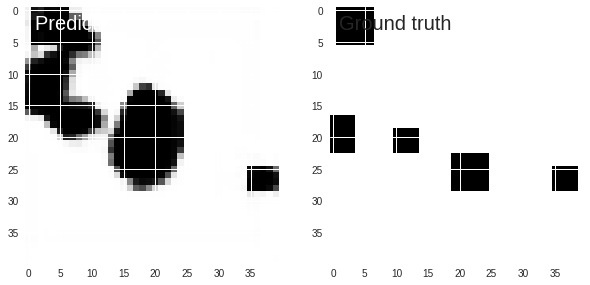

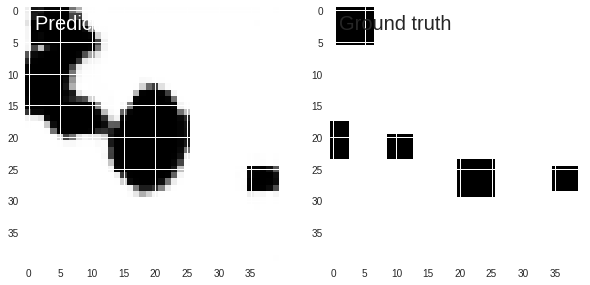

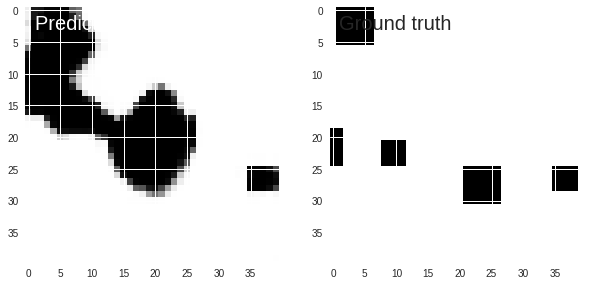

In [0]:
""" This script demonstrates the use of a convolutional LSTM network.
This network is used to predict the next frame of an artificially
generated movie which contains moving squares.
"""
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=5, validation_split=0.05)

# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))

### CuDNNGRU

In [1]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import CuDNNGRU
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(CuDNNGRU(128))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Using TensorFlow backend.


Loading data...
17465344/17464789 [==============================] - 3s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 26s 1ms/step - loss: 0.4210 - acc: 0.7992 - val_loss: 0.3436 - val_acc: 0.8478
Epoch 2/5
25000/25000 [==============================] - 21s 855us/step - loss: 0.2289 - acc: 0.9090 - val_loss: 0.3763 - val_acc: 0.8298
Epoch 3/5
25000/25000 [==============================] - 21s 845us/step - loss: 0.1208 - acc: 0.9559 - val_loss: 0.4861 - val_acc: 0.8285
Epoch 4/5
25000/25000 [==============================] - 21s 839us/step - loss: 0.0585 - acc: 0.9801 - val_loss: 0.5551 - val_acc: 0.8285
Epoch 5/5
25000/25000 [==============================] - 5s 198us/step
Test score: 0.7575144634270669
Test accuracy: 0.82104


### CuDNNLSTM

In [2]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import CuDNNLSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 21s 836us/step - loss: 0.4390 - acc: 0.7948 - val_loss: 0.3945 - val_acc: 0.8276
Epoch 2/5
25000/25000 [==============================] - 20s 808us/step - loss: 0.2583 - acc: 0.8970 - val_loss: 0.3729 - val_acc: 0.8399
Epoch 3/5
25000/25000 [==============================] - 20s 808us/step - loss: 0.1617 - acc: 0.9382 - val_loss: 0.4238 - val_acc: 0.8232
Epoch 4/5
25000/25000 [==============================] - 20s 805us/step - loss: 0.1053 - acc: 0.9618 - val_loss: 0.5954 - val_acc: 0.8155
Epoch 5/5
25000/25000 [==============================] - 5s 198us/step
Test score: 0.5989272013127804
Test accuracy: 0.81916
